# Long-term Analysis

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', start_date = '2022-01-01'):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the price data file.
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index = df['Date']
    df = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]
    df = df.drop(['trend_psar_down', 'trend_psar_up'], axis=1)
    df = df.dropna()

    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    X = df.drop(['Close', 'Date', 'Adj Close'], axis=1)
    
    cols = X.columns
    X = np.array(X)
    X = X.astype(np.float32)

    # Split training and validation data
    split = int(0.8 * len(X))
    X_train = X[:split]
    X_test = X[split:]
    y_train = y[:split]
    y_test = y[split:]

    return X_train, X_test, y_train, y_test, cols

In [3]:
def log_reg(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=float('inf'))
    model = model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(metrics.classification_report(y_test, y_predict))

In [4]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    Run random forest and return model and accuracy score. 
    '''
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [5]:
def adaboost(X_train, X_test, y_train, y_test):
    '''
    Run adaboost and return model and accuracy score. 
    '''   
    model = AdaBoostClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [6]:
def gradient_boost(X_train, X_test, y_train, y_test):
    '''
    Run gradient boosting and return model and accuracy score. 
    '''       
    model = GradientBoostingClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [7]:
def sklearn_cross_validation(df_X, df_y, split, verbose, plot = False):
    '''
    Do cross validation based on ScikitLearn's Time Series Split
    '''
    tscv = TimeSeriesSplit(n_splits=split)

    rf_results = []
    ada_results = []
    gradient_results = []
    rf_feature_imp = np.zeros(df_X.shape[1])
    ada_feature_imp = np.zeros(df_X.shape[1])
    gra_feature_imp = np.zeros(df_X.shape[1])

    for train_index, validation_index in tscv.split(df_X):
        print("TRAIN:", len(train_index), "VALIDATION:", len(validation_index))
        X_train, X_validation = df_X[train_index], df_X[validation_index]
        y_train, y_validation = df_y[train_index], df_y[validation_index]

        t_scaler = MinMaxScaler()
        X_train = t_scaler.fit_transform(X_train)
        X_validation = t_scaler.transform(X_validation)

        if len(np.unique(y_train)) == 1:
            continue
        rf, rf_accuracy, rf_imp = random_forest(X_train, X_validation, y_train, y_validation)
        rf_results.append(rf_accuracy)
        rf_feature_imp = rf_feature_imp + rf_imp
        ada, ada_accuracy, ada_imp = adaboost(X_train, X_validation, y_train, y_validation)
        ada_results.append(ada_accuracy)
        ada_feature_imp = ada_feature_imp + ada_imp
        gra, gra_accuracy, gra_imp = gradient_boost(X_train, X_validation, y_train, y_validation)
        gradient_results.append(gra_accuracy)
        gra_feature_imp = gra_feature_imp + gra_imp

    rf_feature_imp = rf_feature_imp / split
    ada_feature_imp = ada_feature_imp / split
    gra_feature_imp = gra_feature_imp / split

    if verbose:
        print("Mean Accuracy of Random Forests", sum(rf_results)/len(rf_results))
        print("Mean Accuracy of Adaboost", sum(ada_results)/len(ada_results))
        print("Mean Accuracy of Gradient Boosting", sum(gradient_results)/len(gradient_results))
    
    if plot:
        return sum(rf_results)/len(rf_results), sum(ada_results)/len(ada_results), sum(gradient_results)/len(gradient_results)
    return rf_feature_imp, ada_feature_imp, gra_feature_imp

In [8]:
def feature_importance(importances, columns): 
    feature_names = [i for i in columns]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)
    
    print('Top 20 Best Features : \n')
    print(forest_importances.head(20))
    fig, ax = plt.subplots(figsize=(30,20))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

## Apple Stock

In [9]:
X_train, X_test, y_train, y_test, cols_AAPL = prepare_dataset(start_date='2017-01-01')
t_scaler = MinMaxScaler()
X_train = t_scaler.fit_transform(X_train)
X_test = t_scaler.transform(X_test)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [10]:
log_reg(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.69      0.17      0.28       115
           1       0.55      0.93      0.69       123

    accuracy                           0.56       238
   macro avg       0.62      0.55      0.48       238
weighted avg       0.62      0.56      0.49       238



In [11]:
X_train, X_test, y_train, y_test, cols_AAPL = prepare_dataset(start_date='2017-01-01')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [12]:
rf_AAPL, ada_AAPL, gra_AAPL = sklearn_cross_validation(X_train, y_train, 5, True)

TRAIN: 161 VALIDATION: 158
TRAIN: 319 VALIDATION: 158
TRAIN: 477 VALIDATION: 158
TRAIN: 635 VALIDATION: 158
TRAIN: 793 VALIDATION: 158
Mean Accuracy of Random Forests 0.47974683544303803
Mean Accuracy of Adaboost 0.4886075949367089
Mean Accuracy of Gradient Boosting 0.48227848101265824


Top 20 Best Features : 

volume_mfi                 0.036267
volume_obv                 0.033926
momentum_stoch_rsi_d       0.029026
volume_vpt                 0.023927
momentum_stoch_signal      0.022976
trend_mass_index           0.022338
momentum_rsi               0.021899
momentum_roc               0.021367
volume_cmf                 0.020629
volatility_bbw             0.019710
others_dlr                 0.019568
trend_dpo                  0.019371
trend_cci                  0.018936
volume_em                  0.018803
momentum_uo                0.018669
volatility_dcw             0.018367
trend_kst_diff             0.016893
trend_visual_ichimoku_a    0.016689
trend_vortex_ind_neg       0.016660
momentum_stoch_rsi_k       0.016623
dtype: float64


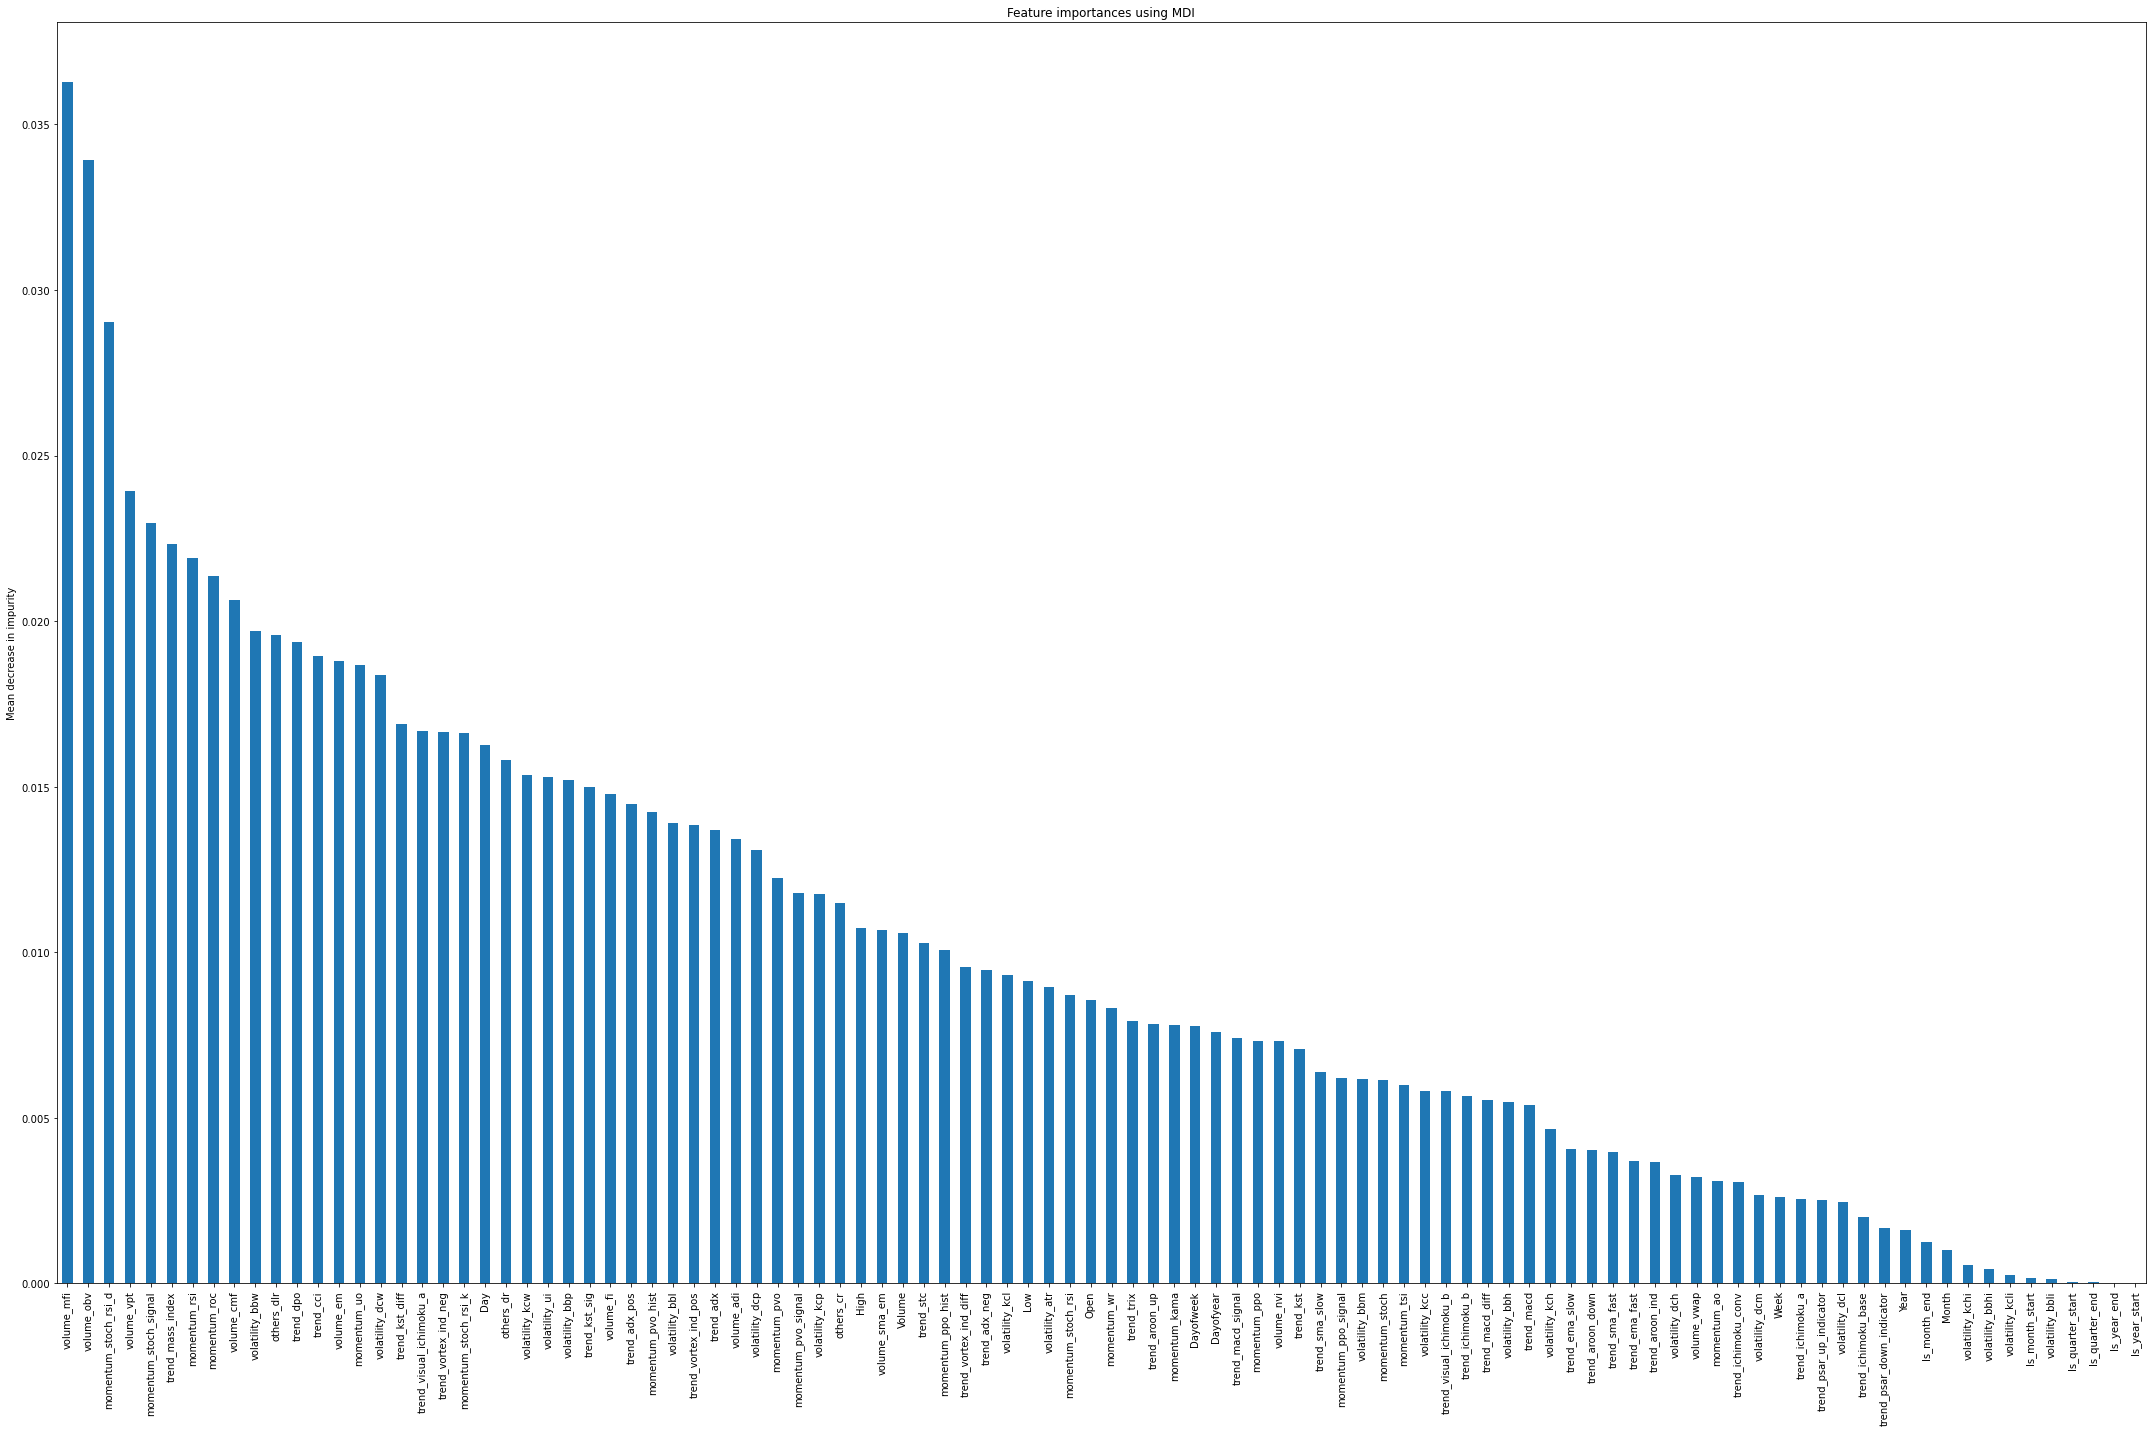

In [13]:
ave_AAPL = (rf_AAPL + ada_AAPL + gra_AAPL) / 3
imp_AAPL = feature_importance(ave_AAPL, cols_AAPL)

In [14]:
print(f"num of training set:{len(X_train)}, num of testing set:{len(X_test)}")

num of training set:951, num of testing set:238


In [15]:
print(f"num of y=1 : {len(y_train[y_train==1])+len(y_test[y_test==1])} \
    num of y=0 : {len(y_train[y_train==0])+len(y_test[y_test==0])}")

num of y=1 : 632     num of y=0 : 557


## Diagnosing bias and variance problems with learning curves
https://github.com/rasbt/machine-learning-book/blob/main/ch06/ch06.ipynb

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


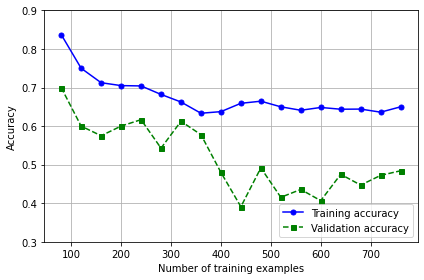

In [18]:
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

def prepare_dataset(path = 'data/AAPL_data.csv', start_date = '2022-01-01'):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the price data file.
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index = df['Date']
    df = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]
    df = df.drop(['trend_psar_down', 'trend_psar_up'], axis=1)
    df = df.dropna()

    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    X = df.drop(['Close', 'Date', 'Adj Close'], axis=1)
    
    X = np.array(X)
    X = X.astype(np.float32)

    return X, y
    
pipe_lr = make_pipeline(MinMaxScaler(),
                        LogisticRegression(max_iter=10000))

train_accs = []
test_accs = []
train_sizes = []
X, y = prepare_dataset(start_date='2017-01-01')
for n in range(100, 1000, 50):
    train_lst = []
    test_lst = []
    new_X = X[-n:]
    new_y = y[-n:]
    # tscv = TimeSeriesSplit(n_splits=5)
    # for train_index, validation_index in tscv.split(new_X):
    #     X_train, X_validation = new_X[train_index], new_X[validation_index]
    #     y_train, y_validation = new_y[train_index], new_y[validation_index]
    #     pipe_lr.fit(X_train, y_train)
    #     y_pred = pipe_lr.predict(X_validation)
    #     train_acc = pipe_lr.score(X_train, y_train)
    #     test_acc = pipe_lr.score(X_validation, y_validation)
    #     train_lst.append(train_acc)
    #     test_lst.append(test_acc)

    # m_train_acc = sum(train_lst)/len(train_lst)
    # m_test_acc = sum(test_lst)/len(test_lst)
    
    # Without CV
    split = int(0.8 * len(new_X))
    X_train = new_X[:split]
    X_test = new_X[split:]
    y_train = new_y[:split]
    y_test = new_y[split:]
    pipe_lr.fit(X_train, y_train)
    y_pred = pipe_lr.predict(X_test)
    train_acc = pipe_lr.score(X_train, y_train)
    test_acc = pipe_lr.score(X_test, y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_sizes.append(n*0.8)

train_scores = np.array(train_accs)
test_scores = np.array(test_accs)
train_sizes = np.array(train_sizes)

plt.plot(train_sizes, train_scores,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.plot(train_sizes, test_scores,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 0.9])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

It seems the training accuracy and validation accuracy approaches as we increase the number of training example. But the overall accuracy is still low. 